In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
dart_file = '../data/Dart/Dart_201909.csv'

### Process Dart data in Sep
We first take data of '20190923_PerStation.csv' as an example.

In [2]:
opal_file = '../data/Opal/20190923_PerStation.csv'
dart_df = pd.read_csv(dart_file)

day_df = dart_df[dart_df.DAY_OF_OPERATION_DATE == '2019-09-23']
day_df.columns

Index(['TRIP_NAME', 'DAY_OF_OPERATION_DATE', 'TPS_PLANNED_ARRIVAL_TIME',
       'PERIODS', 'STATION_NAME', 'TRIP_ORGIN_STATION',
       'TRIP_DESTINATION_STATION', 'TRIP_DURATION_SEC',
       'SEGMENT_DIRECTION_NAME', 'TPS_PLANNED_DEPARTURE_TIME',
       'PLANNED_ARRIVAL_PLATFORM', 'CAR1_PSNGLD_ARRIVE', 'CAR1_PSNGLD_DEPART',
       'CAR2_PSNGLD_ARRIVE', 'CAR2_PSNGLD_DEPART', 'CAR3_PSNGLD_ARRIVE',
       'CAR3_PSNGLD_DEPART', 'CAR4_PSNGLD_ARRIVE', 'CAR4_PSNGLD_DEPART',
       'CAR5_PSNGLD_ARRIVE', 'CAR5_PSNGLD_DEPART', 'CAR6_PSNGLD_ARRIVE',
       'CAR6_PSNGLD_DEPART', 'CAR7_PSNGLD_ARRIVE', 'CAR7_PSNGLD_DEPART',
       'CAR8_PSNGLD_ARRIVE', 'CAR8_PSNGLD_DEPART', 'NODE_SEQ_ORDER'],
      dtype='object')

We get the total car's loading weights by summing all CARs' departure data.

In [3]:
day_df['SUM_DEPART'] = day_df.CAR1_PSNGLD_DEPART + day_df.CAR2_PSNGLD_DEPART + \
                day_df.CAR3_PSNGLD_DEPART + day_df.CAR4_PSNGLD_DEPART + \
                day_df.CAR5_PSNGLD_DEPART + day_df.CAR6_PSNGLD_DEPART + \
                day_df.CAR7_PSNGLD_DEPART + day_df.CAR8_PSNGLD_DEPART

/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:
SHOWN_COLS = ['TRIP_NAME', 'DAY_OF_OPERATION_DATE', 
              'STATION_NAME', 'PLANNED_ARRIVAL_PLATFORM',
             'TRIP_ORGIN_STATION', 'TRIP_DESTINATION_STATION', 'SUM_DEPART',]

day_df[SHOWN_COLS].head()

,TRIP_NAME,DAY_OF_OPERATION_DATE,STATION_NAME,PLANNED_ARRIVAL_PLATFORM,TRIP_ORGIN_STATION,TRIP_DESTINATION_STATION,SUM_DEPART
146,144L,2019-09-23,North Strathfield,NST1,Hornsby,Central,16860.0
6641,146S,2019-09-23,North Strathfield,NST1,Hornsby,Central,NaN
312360,146R,2019-09-23,North Strathfield,NST2,Central,Hornsby,30430.0
312361,148F,2019-09-23,North Strathfield,NST1,Hornsby,Central,58120.0
312362,141P,2019-09-23,North Strathfield,NST1,Hornsby,Central,26860.0


### Process Opal data in Sep
Drop useless colums for clarity.

In [5]:
drop_cols = ['Joined_Trip_Name', 'Leading_Set_Type',
       'TapOnBoard', 'InterchangeBoard', 'TotalBoard', 'TapOffAlight',
       'InterchangeAlight', 'TotalAlight', 'OP_Adult',
       'OP_Child_Youth', 'OP_Concession', 'OP_Senior_Pensioner',
       'OP_School_Student', 'OP_Sgl_Trip_Rail_Adult', 'OP_Employee',
       'OP_Free_Travel', 'OP_Sgl_Trip_Rail_Child_Youth',
       'OP_DayPass_without_SAF', 'OP_UNKNOWN', 'Average_Tap_On_Waiting_Sec',
       'Average_Interchange_On_Waiting_Sec', 'Average_Total_Waiting_Sec',
       'OP_DayPass_Child_Youth_without_SA']

Rename to prepare for merging.

In [6]:
opal_df = pd.read_csv(opal_file)
opal_df = opal_df.drop(columns=drop_cols, axis = 1)
opal_df.rename(columns={'Trip_Name':'TRIP_NAME',
                        'Service_Date':'DAY_OF_OPERATION_DATE',
                       'Origin':'TRIP_ORGIN_STATION',
                       'Destination':'TRIP_DESTINATION_STATION',
                       'Actual_Stop_Station':'STATION_NAME',
                       'Actual_Stop_Node':'PLANNED_ARRIVAL_PLATFORM'}, 
               inplace=True)

We regard one person as 75kg and hence stimate the  number of estimated people (matched_df['EstPeople']) by deviding 75.

We calculate the estimation error (EstError) by matched_df['EstPeople'] - matched_df['OnBoardTotal'].

If the Opal estimation is acceptable, the EstError should roughly obey Gaussian distribution (Bell Curve). And it is really so as our expectation.

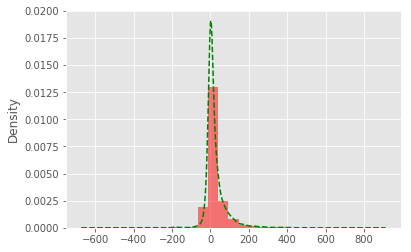

In [7]:
matched_df = pd.merge(day_df, opal_df, 
                                 on=['TRIP_NAME',
                                     'TRIP_ORGIN_STATION',
                                     'TRIP_DESTINATION_STATION',
                                     'STATION_NAME',
                                    'PLANNED_ARRIVAL_PLATFORM',
                                    'DAY_OF_OPERATION_DATE'], 
                                 how='inner')[list(opal_df.columns) + ['SUM_DEPART']]

# We regard one person as 75kg and hence stimate the number of people by 
# deviding 75
matched_df['EstPeople'] = matched_df.SUM_DEPART / 75 

matched_df['EstError'] = matched_df['EstPeople'] - matched_df['OnBoardTotal']

matched_df['EstError'].plot.hist(bins=15, stacked=True, alpha=0.5, density=1,
                                color='r')
matched_df['EstError'].plot.kde(style='g--')

### Show distribution for each of 5 days

We repeat the above process for 5 times and plot the result of each day.

For each day we use pd.df.describe() to to have a feeling for its basic statistics. For example, we show the matched result of day 25/09/2019.

On this day, we matched the total 15859 stopping records; the error *mean* is 19 meaning on average Opal have estimated more or less 19 people against the ground truth (Estimated from summed Dart weights) for one station on a whole train. This sounds not bad!

However, the maximum is around 1095 people. We further investigate as following.
- count    15859.000000
- mean        19.038271
- std         74.520594
- min      -1262.533333
- 25%         -4.800000
- 50%          7.466667
- 75%         30.866667
- max       1095.800000
- Name: EstError, dtype: float64

An record example:
11116	163L	2019-09-25	Central	Gordon	Milsons Point	MPT2	 2019-09-25 15:31:28 2019-09-25 15:32:48	511	120510.0	1606.800000	1095.800000

We see that Opal estimated 511 people would have boarded the train, but the Dart weights is 120510.0, divided by 75(kg/per) giving 1606 people. And the people difference between Optal and Dart is 1095. The possible reasons:
- Dart weight system sucks. This sometimes happen and leads to outliers. But I would rather like the second interpretation.
- Abrupt cases. This station might just suffer some special cases and all waiting people had to rush into this one train. For negtive estimated error, the possible reasons could be ...?
- The matching is not right. Though this is the least possible reason, it still exists. We have careffully designed the matching process to avoid mismachings.

/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


count    17149.000000
mean        22.880592
std         53.016944
min       -276.533333
25%         -2.933333
50%          8.200000
75%         32.533333
max        516.200000
Name: EstError, dtype: float64


/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


count    17254.000000
mean        16.886712
std         41.714816
min       -288.000000
25%         -3.933333
50%          7.200000
75%         29.266667
max        486.466667
Name: EstError, dtype: float64


/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


count    15859.000000
mean        19.038271
std         74.520594
min      -1262.533333
25%         -4.800000
50%          7.466667
75%         30.866667
max       1095.800000
Name: EstError, dtype: float64


/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


count    17548.000000
mean        18.344347
std         43.496898
min       -289.400000
25%         -3.466667
50%          8.733333
75%         30.800000
max        522.600000
Name: EstError, dtype: float64


/Users/kudou/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


count    17734.000000
mean        19.073516
std         48.074500
min       -636.466667
25%         -3.000000
50%          9.800000
75%         32.466667
max        562.333333
Name: EstError, dtype: float64


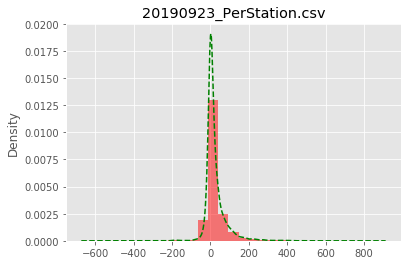

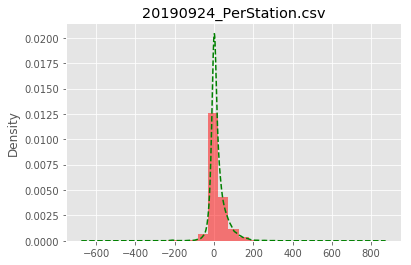

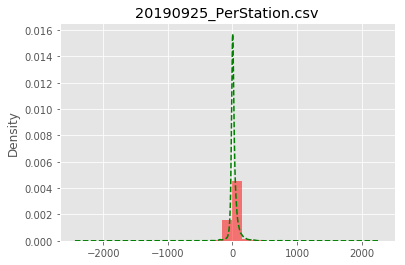

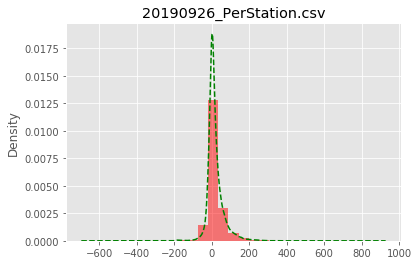

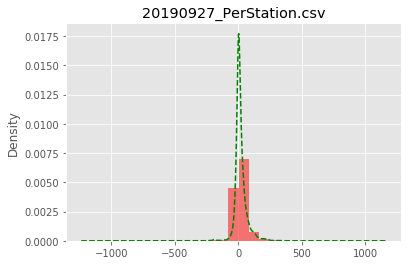

In [8]:
merged_list = []

for d, s in zip(['2019-09-23', '2019-09-24', '2019-09-25', 
                 '2019-09-26', '2019-09-27'], 
                ['20190923_PerStation.csv', '20190924_PerStation.csv', 
                 '20190925_PerStation.csv' , '20190926_PerStation.csv', 
                 '20190927_PerStation.csv']):
    
    ####################
    #process Dart data
    ####################
    day_df = dart_df[dart_df.DAY_OF_OPERATION_DATE == d]
    day_df['SUM_DEPART'] = day_df.CAR1_PSNGLD_DEPART + day_df.CAR2_PSNGLD_DEPART + \
                day_df.CAR3_PSNGLD_DEPART + day_df.CAR4_PSNGLD_DEPART + \
                day_df.CAR5_PSNGLD_DEPART + day_df.CAR6_PSNGLD_DEPART + \
                day_df.CAR7_PSNGLD_DEPART + day_df.CAR8_PSNGLD_DEPART
    
    ####################
    #process opal data
    ####################
    opal_file = '../data/Opal/' + s
    
    opal_df = pd.read_csv(opal_file)
    opal_df = opal_df.drop(columns=drop_cols, axis = 1)
    opal_df.rename(columns={'Trip_Name':'TRIP_NAME',
                            'Service_Date':'DAY_OF_OPERATION_DATE',
                           'Origin':'TRIP_ORGIN_STATION',
                           'Destination':'TRIP_DESTINATION_STATION',
                           'Actual_Stop_Station':'STATION_NAME',
                           'Actual_Stop_Node':'PLANNED_ARRIVAL_PLATFORM'}, 
                   inplace=True)
    
    
    ####################
    #merge data
    ####################
    matched_df = pd.merge(day_df, opal_df, 
                                 on=['TRIP_NAME',
                                     'TRIP_ORGIN_STATION',
                                     'TRIP_DESTINATION_STATION',
                                     'STATION_NAME',
                                    'PLANNED_ARRIVAL_PLATFORM',
                                    'DAY_OF_OPERATION_DATE'], 
                                 how='inner')[list(opal_df.columns) + ['SUM_DEPART']]

    matched_df['EstPeople'] = matched_df.SUM_DEPART / 75 # We regard one person as 75 kg and 
                                            #estimate the number of people

    matched_df['EstError'] = matched_df['EstPeople'] - matched_df['OnBoardTotal']
    
    print(matched_df.EstError.describe())
    
    ####################
    # Plot
    ####################
    plt.figure()
    matched_df['EstError'].plot.hist(bins=15, stacked=True, alpha=0.5, density=1,
                                    color='r')
    matched_df['EstError'].plot.kde(style='g--')
    plt.title(s)
    plt.plot()
    
    merged_list.append(matched_df)

### Show the merged statistics of total 5 days

In [9]:
marged_all = pd.concat(merged_list)
marged_all = marged_all.dropna(how='any')
marged_all.shape

(85544, 12)

In [10]:
marged_all.EstError.describe()

count    85544.000000
mean        19.239536
std         53.056937
min      -1262.533333
25%         -3.533333
50%          8.266667
75%         31.133333
max       1095.800000
Name: EstError, dtype: float64

[]

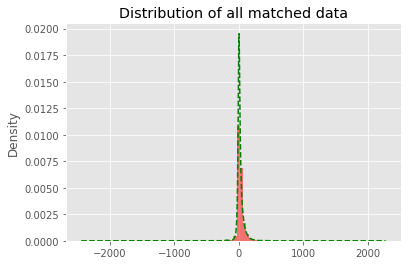

In [11]:
plt.figure()
marged_all['EstError'].plot.hist(bins=50, stacked=True, alpha=0.5, density=1,
                                color='r')
marged_all['EstError'].plot.kde(style='g--')
plt.title('Distribution of all matched data')
plt.plot()

### Analyse the potential outliers.
If we regard the estimated error more than 500 people as outliers, there are total 46 matched outlier results. 

As we can see this outlier cases usully occur on some big stations such as Central, Museum, Chatswood, etc.

In [12]:
marged_all[ abs(marged_all['EstError']) > 500].shape

(62, 12)

In [16]:
marged_all[ abs(marged_all['EstError']) > 500 ]

,TRIP_NAME,DAY_OF_OPERATION_DATE,TRIP_ORGIN_STATION,TRIP_DESTINATION_STATION,STATION_NAME,PLANNED_ARRIVAL_PLATFORM,Actual_Station_Arrv_Time,Actual_Station_Dprt_Time,OnBoardTotal,SUM_DEPART,EstPeople,EstError
5955,139D,2019-09-23,Hornsby,Central,Chatswood,CWD1,2019-09-23 08:34:09,2019-09-23 08:35:09,1061,118290.0,1577.200000,516.200000
11799,141D,2019-09-23,Berowra,Central,Artarmon,ART1,2019-09-23 08:51:23,2019-09-23 08:51:40,625,85020.0,1133.600000,508.600000
778,5--P,2019-09-25,Birrong,Central,Belmore,BMO1,2019-09-25 16:46:05,2019-09-25 16:46:40,1305,5030.0,67.066667,-1237.933333
779,5--P,2019-09-25,Birrong,Central,Campsie,CMP1,2019-09-25 16:48:37,2019-09-25 16:49:18,1276,7790.0,103.866667,-1172.133333
780,5--P,2019-09-25,Birrong,Central,Erskineville,ERS1,2019-09-25 17:05:23,2019-09-25 17:05:50,1188,16200.0,216.000000,-972.000000
781,5--P,2019-09-25,Birrong,Central,Marrickville,MKV1,2019-09-25 16:57:21,2019-09-25 16:58:01,1231,13730.0,183.066667,-1047.933333
782,5--P,2019-09-25,Birrong,Central,Sydenham,SYD1,2019-09-25 17:00:06,2019-09-25 17:00:57,1210,13670.0,182.266667,-1027.733333
784,5--R,2019-09-25,Central,Revesby,Beverly Hills,BVH2,2019-09-25 18:11:17,2019-09-25 18:12:48,305,64860.0,864.800000,559.800000
785,5--R,2019-09-25,Central,Revesby,Green Square,GQU2,2019-09-25 17:46:20,2019-09-25 17:47:46,492,109300.0,1457.333333,965.333333
786,5--R,2019-09-25,Central,Revesby,Mascot,MCO2,2019-09-25 17:49:47,2019-09-25 17:51:17,527,105570.0,1407.600000,880.600000


In [17]:
marged_all.to_csv('../data/diff-People-Opal-DART-Sep.csv', index=False)